# Tracking Parameters and Metrics for Locally Trained Vertex AI Models


## Learning objectives

1. Load and process the training dataset.
2. Start several model training runs.
3. Extract parameters and metrics into a dataframe for analysis.
4. Visualize an experiment's parameters and metrics.

## Introduction

This notebook demonstrates how to track metrics and parameters for ML training jobs and analyze this metadata using Vertex AI SDK for Python.

### Dataset

In this notebook, you will train a simple distributed neural network (DNN) model to predict automobile's miles per gallon (MPG) based on automobile information in the [auto-mpg dataset](https://www.kaggle.com/devanshbesain/exploration-and-analysis-auto-mpg).

Each learning objective will correspond to a __#TODO__ in the [student lab notebook](../labs/sdk-metric-parameter-tracking-for-locally-trained-models.ipynb) -- try to complete that notebook first before reviewing this solution notebook.

## Installation

Install the packages required for executing this notebook.

In [1]:
import os

# The Vertex AI Workbench Notebook product has specific requirements
IS_WORKBENCH_NOTEBOOK = os.getenv("DL_ANACONDA_HOME") and not os.getenv("VIRTUAL_ENV")
IS_USER_MANAGED_WORKBENCH_NOTEBOOK = os.path.exists(
    "/opt/deeplearning/metadata/env_version"
)

# Vertex AI Notebook requires dependencies to be installed with '--user'
USER_FLAG = ""
if IS_WORKBENCH_NOTEBOOK:
    USER_FLAG = "--user"

! pip3 install --upgrade google-cloud-aiplatform {USER_FLAG} -q
! pip3 install -U tensorflow==2.8 {USER_FLAG} -q

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tfx-bsl 1.10.1 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.63.0 which is incompatible.
tfx-bsl 1.10.1 requires pyarrow<7,>=6, but you have pyarrow 9.0.0 which is incompatible.
tfx-bsl 1.10.1 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<3,>=1.15.5, but you have tensorflow 2.8.0 which is incompatible.
tensorflow-transform 1.10.1 requires pyarrow<7,>=6, but you have pyarrow 9.0.0 which is

### Restart the kernel

After you install the additional packages, you need to restart the notebook kernel so it can find the packages.

In [2]:
# Automatically restart kernel after installs
import os

if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

### Set your project ID

**If you don't know your project ID**, you may be able to get your project ID using `gcloud`.

In [1]:
PROJECT_ID = "[your-project-id]"  # Replace with your Project ID

In [2]:
! gcloud config set project $PROJECT_ID

Updated property [core/project].


#### Region

You can also change the `REGION` variable, which is used for operations
throughout the rest of this notebook.  Below are regions supported for Vertex AI. We recommend that you choose the region closest to you.

- Americas: `us-central1`
- Europe: `europe-west4`
- Asia Pacific: `asia-east1`

You may not use a multi-regional bucket for training with Vertex AI. Not all regions provide support for all Vertex AI services.

Learn more about [Vertex AI regions](https://cloud.google.com/vertex-ai/docs/general/locations)

In [3]:
REGION = "us-central1"  # Replace with your region

#### Timestamp

If you are in a live tutorial session, you might be using a shared test account or project. To avoid name collisions between users on resources created, you create a timestamp for each instance session, and append it onto the name of resources you create in this tutorial.

In [4]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

### Import libraries and define constants

Import required libraries.

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
from google.cloud import aiplatform
from tensorflow.python.keras import Sequential, layers
from tensorflow.python.keras.utils import data_utils

Define some constants

In [6]:
EXPERIMENT_NAME = "my-experiment"  # Replace with the name of your choice

If EXEPERIMENT_NAME is not set, set a default one below:

In [ ]:
if EXPERIMENT_NAME == "" or EXPERIMENT_NAME is None:
    EXPERIMENT_NAME = "my-experiment-" + TIMESTAMP

## Concepts

To better understanding how parameters and metrics are stored and organized, we'd like to introduce the following concepts:


### Experiment
Experiments describe a context that groups your runs and the artifacts you create into a logical session. For example, in this notebook you create an Experiment and log data to that experiment.

### Run
A run represents a single path/avenue that you executed while performing an experiment. A run includes artifacts that you used as inputs or outputs, and parameters that you used in this execution. An Experiment can contain multiple runs. 

## Getting started tracking parameters and metrics

You can use the Vertex SDK for Python to track metrics and parameters for models trained locally. 

In the following example, you train a simple distributed neural network (DNN) model to predict automobile's miles per gallon (MPG) based on automobile information in the [auto-mpg dataset](https://www.kaggle.com/devanshbesain/exploration-and-analysis-auto-mpg).

### Load and process the training dataset

Download and process the dataset.

In [7]:
def read_data(uri):
    dataset_path = data_utils.get_file("auto-mpg.data", uri)
    column_names = [
        "MPG",
        "Cylinders",
        "Displacement",
        "Horsepower",
        "Weight",
        "Acceleration",
        "Model Year",
        "Origin",
    ]
    raw_dataset = pd.read_csv(
        dataset_path,
        names=column_names,
        na_values="?",
        comment="\t",
        sep=" ",
        skipinitialspace=True,
    )
    dataset = raw_dataset.dropna()
    dataset["Origin"] = dataset["Origin"].map(
        lambda x: {1: "USA", 2: "Europe", 3: "Japan"}.get(x)
    )
    dataset = pd.get_dummies(dataset, prefix="", prefix_sep="")
    return dataset


dataset = read_data(
    "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
)

32768/30286 [================================] - 0s 1us/step


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Split dataset for training and testing.

In [8]:
def train_test_split(dataset, split_frac=0.8, random_state=0):
    train_dataset = dataset.sample(frac=split_frac, random_state=random_state)
    test_dataset = dataset.drop(train_dataset.index)
    train_labels = train_dataset.pop("MPG")
    test_labels = test_dataset.pop("MPG")

    return train_dataset, test_dataset, train_labels, test_labels


train_dataset, test_dataset, train_labels, test_labels = train_test_split(dataset)

Normalize the features in the dataset for better model performance.

In [9]:
def normalize_dataset(train_dataset, test_dataset):
    train_stats = train_dataset.describe()
    train_stats = train_stats.transpose()

    def norm(x):
        return (x - train_stats["mean"]) / train_stats["std"]

    normed_train_data = norm(train_dataset)
    normed_test_data = norm(test_dataset)

    return normed_train_data, normed_test_data


normed_train_data, normed_test_data = normalize_dataset(train_dataset, test_dataset)

### Define ML model and training function

In [10]:
# Define the model training
def train(
    train_data,
    train_labels,
    num_units=64,
    activation="relu",
    dropout_rate=0.0,
    validation_split=0.2,
    epochs=1000,
):

    model = Sequential(
        [
            layers.Dense(
                num_units,
                activation=activation,
                input_shape=[len(train_dataset.keys())],
            ),
            layers.Dropout(rate=dropout_rate),
            layers.Dense(num_units, activation=activation),
            layers.Dense(1),
        ]
    )

    model.compile(loss="mse", optimizer="adam", metrics=["mae", "mse"])
    print(model.summary())

    history = model.fit(
        train_data, train_labels, epochs=epochs, validation_split=validation_split
    )

    return model, history

### Initialize the Vertex AI SDK for Python and create an Experiment

Initialize the *client* for Vertex AI and create an experiment.

In [11]:
# Initialize the Vertex AI SDK for Python
aiplatform.init(project=PROJECT_ID, location=REGION, experiment=EXPERIMENT_NAME)

### Start several model training runs

Training parameters and metrics are logged for each run.

In [12]:
parameters = [
    {"num_units": 16, "epochs": 3, "dropout_rate": 0.1},
    {"num_units": 16, "epochs": 10, "dropout_rate": 0.1},
    {"num_units": 16, "epochs": 10, "dropout_rate": 0.2},
    {"num_units": 32, "epochs": 10, "dropout_rate": 0.1},
    {"num_units": 32, "epochs": 10, "dropout_rate": 0.2},
]

for i, params in enumerate(parameters):
    aiplatform.start_run(run=f"auto-mpg-local-run-{i}")
    aiplatform.log_params(params)
    model, history = train(
        normed_train_data,
        train_labels,
        num_units=params["num_units"],
        activation="relu",
        epochs=params["epochs"],
        dropout_rate=params["dropout_rate"],
    )
    aiplatform.log_metrics(
        {metric: values[-1] for metric, values in history.history.items()}
    )

    loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
    aiplatform.log_metrics({"eval_loss": loss, "eval_mae": mae, "eval_mse": mse})

Associating projects/62613708561/locations/us-central1/metadataStores/default/contexts/my-experiment-auto-mpg-local-run-0 to Experiment: my-experiment


INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/62613708561/locations/us-central1/metadataStores/default/contexts/my-experiment-auto-mpg-local-run-0 to Experiment: my-experiment
2022-10-14 13:13:49.748848: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2022-10-14 13:13:49.748909: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-14 13:13:49.748948: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tensorflow-2-6-20221014-181307): /proc/driver/nvidia/version does not exist
2022-10-14 13:13:49.749275: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                160       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
8/8 [==============================] - 1s 28ms/step - loss: 617.4069 - mae: 23.6673 - mse: 617.4069 - val_loss: 636.9465 - val_mae: 24.0385 - val_mse: 636.9465
Epoch 2/3
8/8 [==============================] - 0s 5ms/step - loss: 609.2305 - m

INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/62613708561/locations/us-central1/metadataStores/default/contexts/my-experiment-auto-mpg-local-run-1 to Experiment: my-experiment


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                160       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
8/8 [==============================] - 1s 23ms/step - loss: 643.3784 - mae: 24.2875 - mse: 643.3784 - val_loss: 667.1874 - val_mae: 24.7708 - val_mse: 667.1874
Epoch 2/10
8/8 [==============================] - 0s 4ms/step - loss: 630.0400

INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/62613708561/locations/us-central1/metadataStores/default/contexts/my-experiment-auto-mpg-local-run-2 to Experiment: my-experiment


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 16)                160       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
8/8 [==============================] - 1s 52ms/step - loss: 625.0442 - mae: 23.7135 - mse: 625.0442 - val_loss: 644.3045 - val_mae: 24.0982 - val_mse: 644.3045
Epoch 2/10
8/8 [==============================] - 0s 5ms/step - loss: 616.0950

INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/62613708561/locations/us-central1/metadataStores/default/contexts/my-experiment-auto-mpg-local-run-3 to Experiment: my-experiment


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 32)                320       
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 1,409
Trainable params: 1,409
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
8/8 [==============================] - 1s 23ms/step - loss: 602.7513 - mae: 23.3620 - mse: 602.7513 - val_loss: 620.4725 - val_mae: 23.6947 - val_mse: 620.4725
Epoch 2/10
8/8 [==============================] - 0s 4ms/step - loss: 590.

INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/62613708561/locations/us-central1/metadataStores/default/contexts/my-experiment-auto-mpg-local-run-4 to Experiment: my-experiment


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 32)                320       
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 33        
Total params: 1,409
Trainable params: 1,409
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
8/8 [==============================] - 1s 24ms/step - loss: 600.9067 - mae: 23.3580 - mse: 600.9067 - val_loss: 613.7952 - val_mae: 23.6214 - val_mse: 613.7952
Epoch 2/10
8/8 [==============================] - 0s 5ms/step - loss: 584.

### Extract parameters and metrics into a dataframe for analysis

We can also extract all parameters and metrics associated with any Experiment into a dataframe for further analysis.

In [13]:
# Extract all parameters and metrics into a dataframe
experiment_df = aiplatform.get_experiment_df()
experiment_df

,experiment_name,run_name,run_type,state,param.num_units,param.epochs,param.dropout_rate,metric.mse,metric.loss,metric.val_mse,metric.mae,metric.eval_mae,metric.eval_loss,metric.val_loss,metric.eval_mse,metric.val_mae
0,my-experiment,auto-mpg-local-run-4,system.ExperimentRun,RUNNING,32.0,10.0,0.2,408.652954,408.652954,401.899109,19.125265,19.097095,408.607178,401.899109,408.607178,18.947227
1,my-experiment,auto-mpg-local-run-3,system.ExperimentRun,COMPLETE,32.0,10.0,0.1,435.841644,435.841644,423.952118,19.208683,19.375414,447.849457,423.952118,447.849457,18.802963
2,my-experiment,auto-mpg-local-run-2,system.ExperimentRun,COMPLETE,16.0,10.0,0.2,562.760376,562.760376,578.414795,22.385078,23.075970,600.690125,578.414795,600.690125,22.689171
3,my-experiment,auto-mpg-local-run-1,system.ExperimentRun,COMPLETE,16.0,10.0,0.1,527.841125,527.841125,535.405518,21.932697,22.426222,551.543640,535.405518,551.543640,22.135757
4,my-experiment,auto-mpg-local-run-0,system.ExperimentRun,COMPLETE,16.0,3.0,0.1,601.763550,601.763550,621.349182,23.259560,23.913794,639.931274,621.349182,639.931274,23.619804


### Visualizing an experiment's parameters and metrics

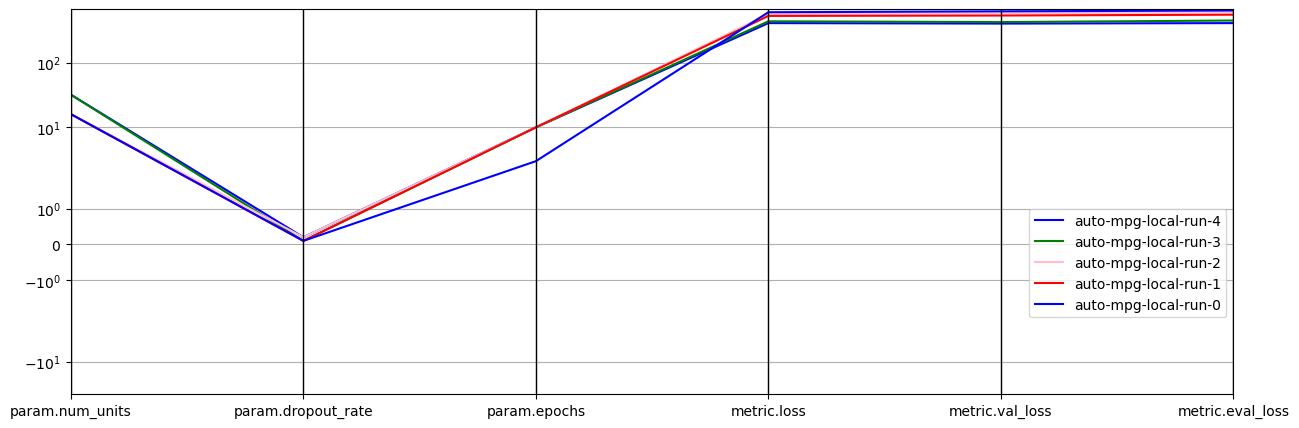

In [14]:
plt.rcParams["figure.figsize"] = [15, 5]

ax = pd.plotting.parallel_coordinates(
    experiment_df.reset_index(level=0),
    "run_name",
    cols=[
        "param.num_units",
        "param.dropout_rate",
        "param.epochs",
        "metric.loss",
        "metric.val_loss",
        "metric.eval_loss",
    ],
    color=["blue", "green", "pink", "red"],
)
ax.set_yscale("symlog")
ax.legend(bbox_to_anchor=(1.0, 0.5))

## Visualizing experiments in Cloud Console

Run the following to get the URL of Vertex AI Experiments for your project.


In [15]:
print("Vertex AI Experiments:")
print(
    f"https://console.cloud.google.com/ai/platform/experiments/experiments?folder=&organizationId=&project={PROJECT_ID}"
)

Vertex AI Experiments:
https://console.cloud.google.com/ai/platform/experiments/experiments?folder=&organizationId=&project=qwiklabs-gcp-00-367d77ca87e3


## Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:

- Experiment (Can be deleted manually in the GCP Console UI)